# <center> Speech Emotion Recognition </center> 

In [1]:
import numpy as np
import pandas as pd 

import os
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import librosa  
import librosa.display

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn import preprocessing

from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras import callbacks

from tqdm import tqdm
from IPython.display import Audio, display

In [2]:

files_Path="C:/Users/DELL/Downloads/archive (4)/AudioWAV"

c_emotions = {
    'NEU':'neutral',
    'HAP':'happy',
    'SAD':'sad',
    'ANG':'angry',
    'FEA':'fear',
    'DIS':'disgust'}

c_file = []
for wav in os.listdir(files_Path):
    emo = wav.partition(".wav")[0].split('_')
    emotion = c_emotions[emo[2]]
    c_file.append((files_Path+'/'+wav,emotion))
    
data_df = pd.DataFrame(c_file, columns = ['File_path', 'Emotion'])
data_df.to_csv('data_df.csv')
data_df.shape
data_df.head(10)

,File_path,Emotion
0,C:/Users/DELL/Downloads/archive (4)/AudioWAV/1...,angry
1,C:/Users/DELL/Downloads/archive (4)/AudioWAV/1...,disgust
2,C:/Users/DELL/Downloads/archive (4)/AudioWAV/1...,fear
3,C:/Users/DELL/Downloads/archive (4)/AudioWAV/1...,happy
4,C:/Users/DELL/Downloads/archive (4)/AudioWAV/1...,neutral
5,C:/Users/DELL/Downloads/archive (4)/AudioWAV/1...,sad
6,C:/Users/DELL/Downloads/archive (4)/AudioWAV/1...,angry
7,C:/Users/DELL/Downloads/archive (4)/AudioWAV/1...,angry
8,C:/Users/DELL/Downloads/archive (4)/AudioWAV/1...,angry
9,C:/Users/DELL/Downloads/archive (4)/AudioWAV/1...,disgust


## Data Analysis and Processing

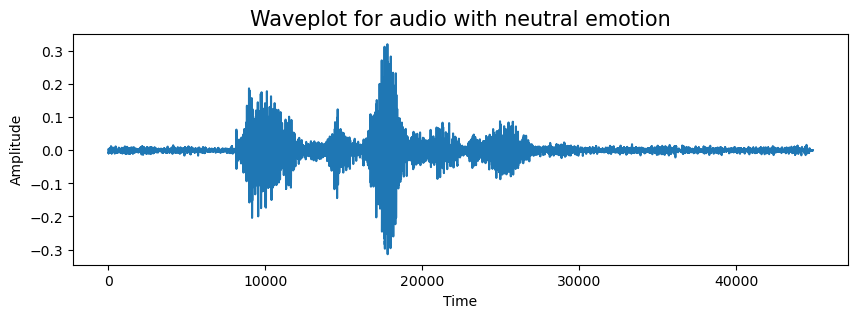

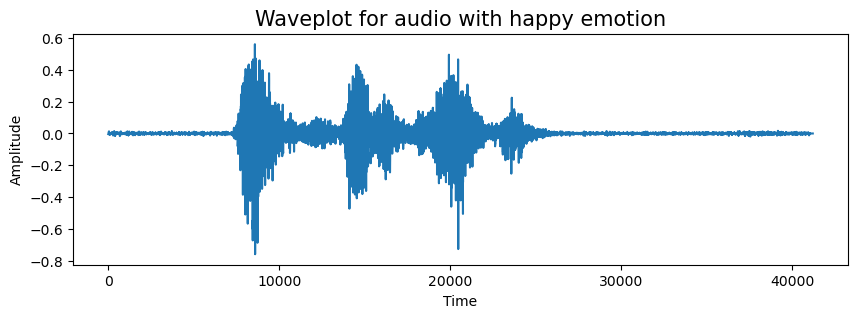

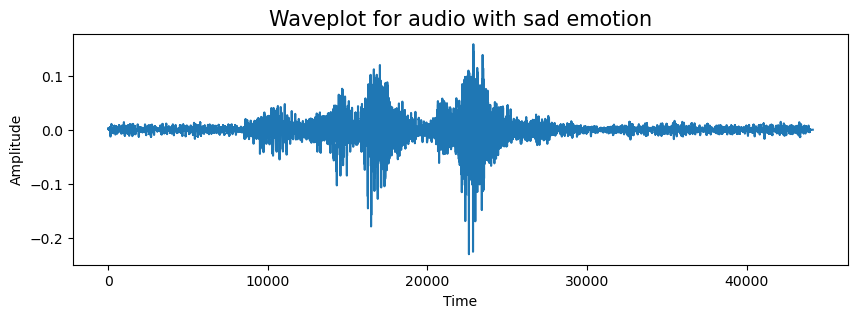

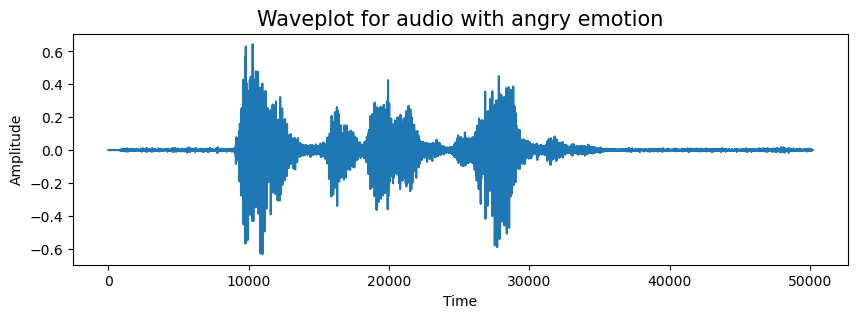

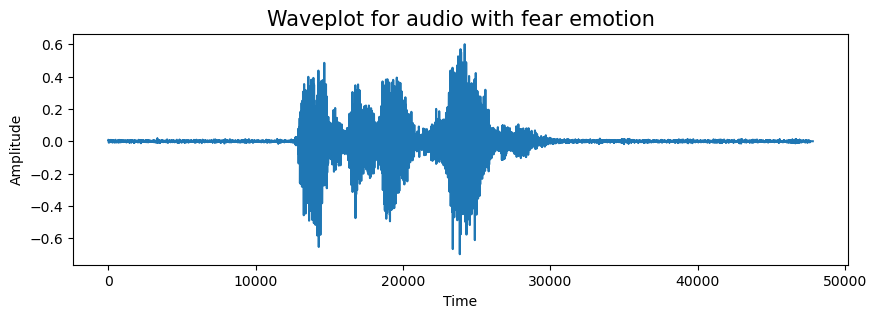

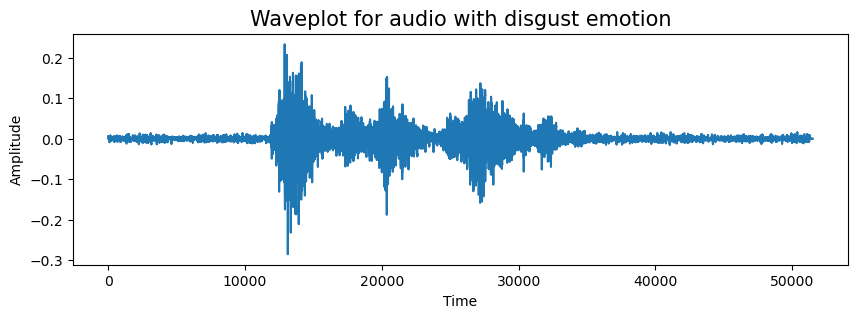

In [3]:
def create_waveplot(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {emotion} emotion', size=15)
    plt.plot(data)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

for emotion in c_emotions.values():
    path = (data_df[data_df.Emotion == emotion].iloc[0])[0]
    data, sampling_rate = librosa.load(path)
    create_waveplot(data,sampling_rate,emotion)
    display(Audio(path))


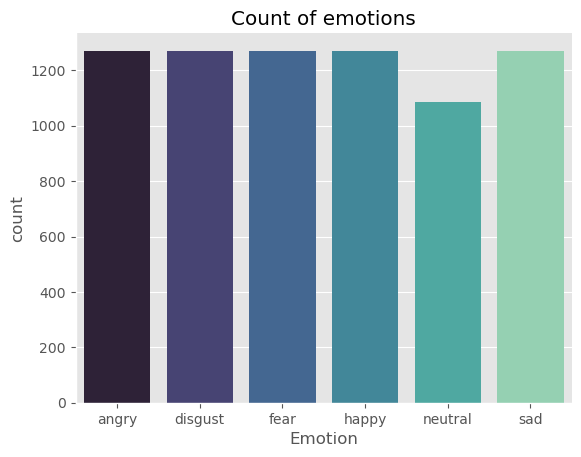

In [4]:
plt.style.use("ggplot")
plt.title("Count of emotions")
sns.countplot(x = data_df["Emotion"], palette= "mako")
sns.despine(top = True, right = True, left = False, bottom = False)

In [5]:
def add_noise(data,random=False,rate=0.035,threshold=0.075):
    if random:
        rate=np.random.random()*threshold
    noise=rate*np.random.uniform()*np.amax(data)
    augmented_data=data+noise*np.random.normal(size=data.shape[0])
    return augmented_data


In [6]:
def pitching(data,sr,pitch_factor=0.7,random=False):
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(y=data,sr=sr,n_steps=pitch_factor)


In [7]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)

In [8]:
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)

In [9]:
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)


In [10]:
def extract_features(data,sr,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

In [11]:
def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data,sr)
    audio=np.array(aud)
    
    noised_audio=add_noise(data,random=True)
    aud2=extract_features(noised_audio,sr)
    audio=np.vstack((audio,aud2))
    
    pitched_audio=pitching(data,sr,random=True)
    aud3=extract_features(pitched_audio,sr)
    audio=np.vstack((audio,aud3))
    
    return audio

In [12]:
X, Y = [], []

for path, emotion, index in zip(data_df.File_path, data_df.Emotion, range(data_df.File_path.shape[0])):
    features = get_features(path)
    if index % 500 == 0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)

print('Done')

0 audio has been processed
500 audio has been processed
1000 audio has been processed
1500 audio has been processed
2000 audio has been processed
2500 audio has been processed
3000 audio has been processed
3500 audio has been processed
4000 audio has been processed
4500 audio has been processed
5000 audio has been processed
5500 audio has been processed
6000 audio has been processed
6500 audio has been processed
7000 audio has been processed
Done


In [13]:
processed_data_path='./processed_data.csv'

In [14]:
extract=pd.DataFrame(X)
extract['Emotion']=Y
extract.to_csv(processed_data_path,index=False)
extract.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotion
0,0.034180,0.069336,0.115723,0.148926,0.142090,0.130859,0.101562,0.070801,0.069336,0.074219,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angry
1,0.170898,0.274902,0.393555,0.415527,0.351074,0.293457,0.220703,0.188477,0.252930,0.253906,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angry
2,0.037109,0.081055,0.127441,0.141602,0.137207,0.116211,0.085938,0.074707,0.065918,0.067383,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,angry
3,0.041504,0.059082,0.070312,0.062988,0.080566,0.128906,0.145508,0.146484,0.125977,0.072266,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,disgust
4,0.041504,0.059082,0.070312,0.061035,0.081543,0.129883,0.145508,0.147461,0.125977,0.071289,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,disgust
5,0.042480,0.058594,0.071289,0.063477,0.085938,0.116211,0.125488,0.125488,0.105469,0.074707,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,disgust
6,0.052734,0.069336,0.087402,0.068848,0.076660,0.075684,0.077637,0.078613,0.072266,0.084961,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
7,0.054688,0.073242,0.107422,0.104980,0.145020,0.149902,0.141113,0.133301,0.104492,0.112305,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
8,0.052734,0.067871,0.081543,0.069824,0.065918,0.077148,0.084961,0.082520,0.081543,0.081055,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
9,0.057617,0.083984,0.104004,0.118652,0.099121,0.087402,0.078125,0.055664,0.136719,0.196289,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,happy


In [15]:
data=pd.read_csv(processed_data_path)

In [16]:
data.shape

(22326, 2377)

In [17]:
data=data.fillna(0)
print(data.isna().any())

0          False
1          False
2          False
3          False
4          False
           ...  
2372       False
2373       False
2374       False
2375       False
Emotion    False
Length: 2377, dtype: bool


In [18]:
data.shape

(22326, 2377)

In [19]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotion
0,0.034180,0.069336,0.115723,0.148926,0.142090,0.130859,0.101562,0.070801,0.069336,0.074219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry
1,0.170898,0.274902,0.393555,0.415527,0.351074,0.293457,0.220703,0.188477,0.252930,0.253906,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry
2,0.037109,0.081055,0.127441,0.141602,0.137207,0.116211,0.085938,0.074707,0.065918,0.067383,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry
3,0.041504,0.059082,0.070312,0.062988,0.080566,0.128906,0.145508,0.146484,0.125977,0.072266,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,disgust
4,0.041504,0.059082,0.070312,0.061035,0.081543,0.129883,0.145508,0.147461,0.125977,0.071289,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,disgust


In [20]:
data.tail()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotion
22321,0.050781,0.131348,0.238770,0.341309,0.435059,0.459473,0.439453,0.394531,0.318848,0.235840,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral
22322,0.030762,0.093262,0.200195,0.294434,0.391113,0.423340,0.405273,0.368164,0.275391,0.201172,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral
22323,0.216309,0.252441,0.308105,0.197266,0.123047,0.103516,0.067871,0.074707,0.070801,0.068359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sad
22324,0.223145,0.264160,0.322754,0.210938,0.131836,0.107422,0.068848,0.075684,0.079102,0.087891,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sad
22325,0.213867,0.265625,0.302246,0.195801,0.131348,0.104980,0.087891,0.086914,0.082031,0.068848,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sad


In [21]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,2366,2367,2368,2369,2370,2371,2372,2373,2374,2375
count,22326.000000,22326.000000,22326.000000,22326.000000,22326.000000,22326.000000,22326.000000,22326.000000,22326.000000,22326.000000,...,22326.000000,22326.000000,22326.000000,22326.000000,22326.000000,22326.000000,22326.000000,22326.000000,22326.000000,22326.000000
mean,0.049738,0.074418,0.099143,0.098514,0.097965,0.097576,0.097174,0.096989,0.097156,0.097208,...,-0.186361,-0.299287,-0.002676,-0.769043,-0.053278,-0.875083,-0.116020,-0.729077,-0.207952,-0.503606
std,0.052875,0.076481,0.098224,0.095868,0.093298,0.091569,0.090515,0.090067,0.089592,0.089134,...,1.943231,1.918213,2.027086,2.798983,1.923804,3.033713,1.878042,2.571617,1.808276,2.134954
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-35.128506,-20.545139,-27.748611,-34.436974,-18.704214,-30.677132,-24.222986,-28.613222,-26.162067,-28.886473
25%,0.019531,0.030273,0.041504,0.041992,0.042969,0.043457,0.043457,0.043945,0.044434,0.044922,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.028809,0.043945,0.060547,0.061523,0.062500,0.062988,0.063477,0.063965,0.063965,0.064453,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.051758,0.079102,0.108887,0.107422,0.107422,0.108398,0.108887,0.107910,0.107910,0.108398,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.303711,0.450195,0.599609,0.584473,0.587402,0.585449,0.561035,0.583008,0.602051,0.586426,...,22.451645,17.844368,23.474030,16.144152,29.785248,25.356298,22.671396,13.412320,38.410912,23.622711


In [24]:
from keras import utils as np_utils
X=data.drop(labels='Emotion',axis=1)
Y=data['Emotion']
lb=LabelEncoder()
Y=np_utils.to_categorical(lb.fit_transform(Y))
print(lb.classes_)
Y

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']


array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

## Splitting the dataset

In [26]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,random_state=32,test_size=0.2,shuffle=True)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((17860, 2376), (4466, 2376), (17860, 6), (4466, 6))

In [27]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,random_state=32,test_size=0.1,shuffle=True)
X_train.shape, X_test.shape, X_val.shape, y_train.shape,y_test.shape,y_val.shape

((16074, 2376), (4466, 2376), (1786, 2376), (16074, 6), (4466, 6), (1786, 6))

In [28]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
X_val=scaler.transform(X_val)
X_train.shape,X_test.shape,X_val.shape,y_train.shape,y_test.shape,y_val.shape

((16074, 2376), (4466, 2376), (1786, 2376), (16074, 6), (4466, 6), (1786, 6))

In [29]:
X_train=np.expand_dims(X_train,axis=2)
X_val=np.expand_dims(X_val,axis=2)
X_test=np.expand_dims(X_test,axis=2)
X_train.shape, X_test.shape, X_val.shape

((16074, 2376, 1), (4466, 2376, 1), (1786, 2376, 1))

## Model Training

In [30]:
import tensorflow.keras.layers as L
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau

In [31]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.1, min_lr=0.00001)

In [32]:
EPOCH=50
BATCH_SIZE=30

In [33]:
model=tf.keras.Sequential([
    L.Conv1D(32,kernel_size=6, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(64,kernel_size=6,strides=1,padding='same',activation='relu'),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(128,kernel_size=6,strides=1,padding='same',activation='relu'),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Flatten(),
    L.Dense(256,activation='relu'),
    L.Dropout(0.5),
    L.Dense(6,activation='softmax')
])


In [34]:
model.compile(optimizer='nadam',loss='categorical_crossentropy',metrics='accuracy')


In [35]:
history = model.fit(X_train, y_train, epochs=EPOCH, validation_data=(X_val,y_val), batch_size=BATCH_SIZE, callbacks=[early_stop,lr_reduction])

Epoch 1/50
536/536 [==============================] - 185s 341ms/step - loss: 1.5591 - accuracy: 0.3638 - val_loss: 1.4570 - val_accuracy: 0.3964 - lr: 0.0010
Epoch 2/50
536/536 [==============================] - 190s 354ms/step - loss: 1.4330 - accuracy: 0.4186 - val_loss: 1.3930 - val_accuracy: 0.4440 - lr: 0.0010
Epoch 3/50
536/536 [==============================] - 179s 333ms/step - loss: 1.3854 - accuracy: 0.4458 - val_loss: 1.3620 - val_accuracy: 0.4546 - lr: 0.0010
Epoch 4/50
536/536 [==============================] - 176s 329ms/step - loss: 1.3349 - accuracy: 0.4672 - val_loss: 1.3434 - val_accuracy: 0.4670 - lr: 0.0010
Epoch 5/50
536/536 [==============================] - 174s 325ms/step - loss: 1.2755 - accuracy: 0.4914 - val_loss: 1.2748 - val_accuracy: 0.4966 - lr: 0.0010
Epoch 6/50
536/536 [==============================] - 176s 328ms/step - loss: 1.2124 - accuracy: 0.5200 - val_loss: 1.2411 - val_accuracy: 0.5106 - lr: 0.0010
Epoch 7/50
536/536 [==========================

In [36]:
val_accuracy = np.mean(history.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy', val_accuracy*100))


val_accuracy: 66.04%

val_accuracy: 66.04%


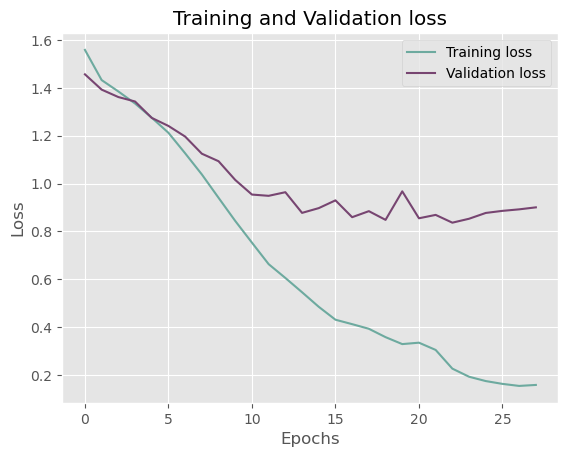

In [37]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#6daa9f", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#774571", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

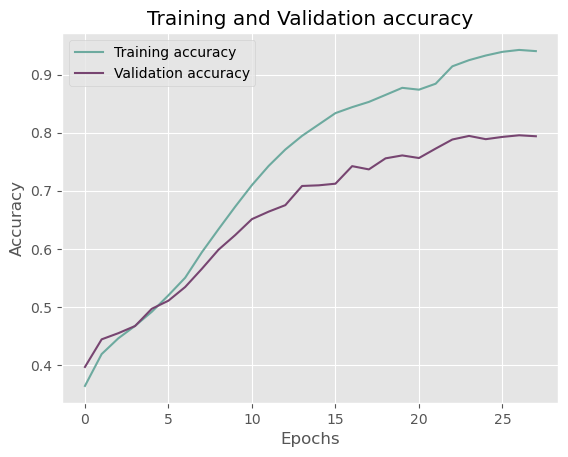

In [38]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#6daa9f", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#774571", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [39]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
np.set_printoptions()

140/140 [==============================] - 6s 39ms/step


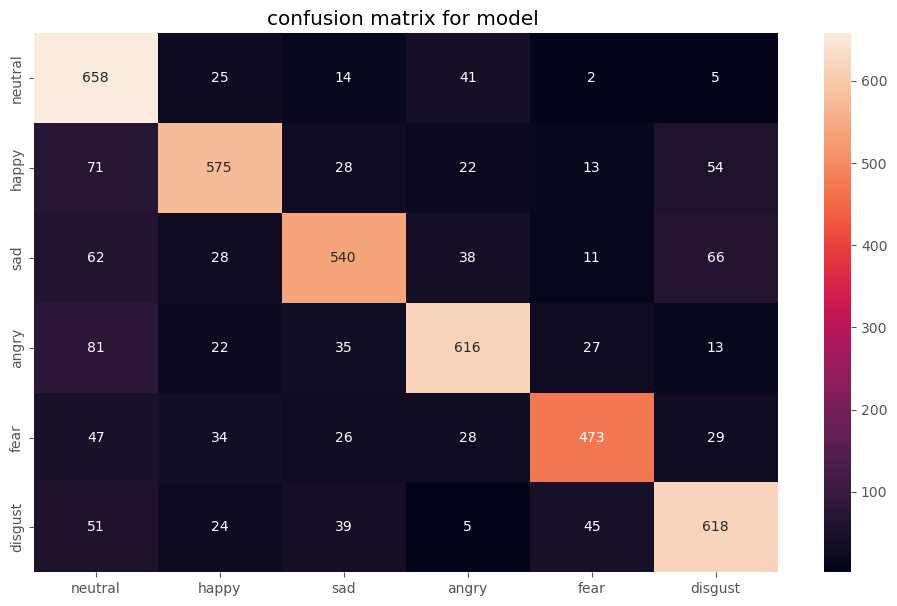

In [42]:
import seaborn as sns
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)
conf=confusion_matrix(y_test_labels,y_pred_labels)
cmap1 = sns.diverging_palette(275,100,  s=40, l=65, n=6)
cm=pd.DataFrame(
    conf,index=[i for i in c_emotions.values()],
    columns=[i for i in c_emotions.values()]
)
plt.figure(figsize=(12,7))
ax=sns.heatmap(cm,annot=True,fmt='d')
ax.set_title(f'confusion matrix for model ')
plt.show()

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2376, 32)          224       
                                                                 
 max_pooling1d (MaxPooling1  (None, 1188, 32)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 1188, 64)          12352     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 594, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 594, 128)          49280     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 297, 128)          0